In [125]:
%reload_ext autoreload
%autoreload 2

import pandas, numpy, sklearn
from local_surrogate_analysis import *
from synthetic_datasets import *
%pylab inline
from sklearn.metrics import pairwise_distances
import ugs_new_cap as gs


Populating the interactive namespace from numpy and matplotlib


/home/laugel/Documents/thesis/code/new_envp36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['clf', 'test', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


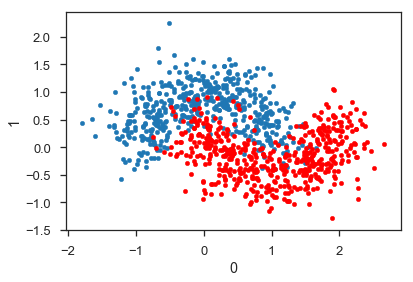

In [126]:
## Get dataset

X, y = get_moons(n_samples=1000, random_state=4)

ylabels = ['Class 0', 'Class 1']
feature_names = ['feature 0', 'feature 1']

fig, ax = subplots(1)
X[y==0].plot(kind='scatter', x=0, y=1, ax=ax)
X[y==1].plot(kind='scatter', x=0, y=1, ax=ax, c='r')

In [127]:
## Train a back-box classifier on the synthetic dataset
import sklearn.model_selection, sklearn.ensemble

train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(X, y, test_size=0.20)

clf = sklearn.ensemble.RandomForestClassifier(n_estimators=200)
clf.fit(train, labels_train)
print(sklearn.metrics.accuracy_score(labels_test, clf.predict(test)))
print(sklearn.metrics.classification_report(labels_test, clf.predict(test)))

0.955
             precision    recall  f1-score   support

          0       0.97      0.94      0.95        96
          1       0.94      0.97      0.96       104

avg / total       0.96      0.95      0.95       200



/home/laugel/Documents/thesis/code/new_envp36/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


Exploring...
Final radius (0.2227792206135786, 0.2255076477383248)
Final number of iterations 45
original observation 0   -0.7
1    0.6
dtype: float64
closest returned [-0.47903414  0.62729715]
lab ['LS', 'LIME (default)', 'LIMEK (kw=0.5)']


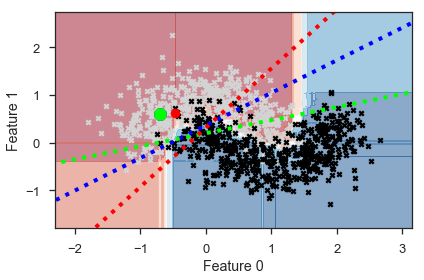

In [133]:
xs_toexplain = [pandas.Series([-0.8,0]), pandas.Series([-0.7,0.6]), pandas.Series([-0.3,1.1]), pandas.Series([0.5,1]), pandas.Series([1, 0.5])]
x_toexplain = pandas.Series([-0.7, 0.6])#xs_toexplain[0]##



closest_enn, _ = gs.main(clf.predict, x_toexplain.reshape(1,-1), n_layer=1000, first_radius=0.1, step_size=1000)

def generate_inside_ball(center, segment=(0,1), n=1):
    def norm(v):
        return np.linalg.norm(v, ord=2, axis=1)
    d = center.shape[1]
    z = np.random.normal(0, 1, (n, d))
    z = np.array([a * b / c for a, b, c in zip(z, np.random.uniform(*segment, n),  norm(z))])
    z = z + center
    return z # les z sont a distance de center comprise dans le segment 


X_local = generate_inside_ball(closest_enn.reshape(1,- 1), segment=(0, 0.3), n=1000)

y_local = clf.predict_proba(X_local)[:, 1]

from sklearn import linear_model
lr = linear_model.LinearRegression()
lr = lr.fit(X_local, y_local)

coefs = lr.coef_

intercept = lr.intercept_
x1s = [X.iloc[:,0].min(), X.iloc[:,0].max()]
y1s = [((0.5 - intercept - x1*coefs[0])/coefs[1]) for x1 in x1s]


#ax = plt.subplot()
#plot_classification_contour(X, clf, ax)
#plot_training_set(X, y, ax)
ylim_bak = ax.get_ylim()
color_palette = sns.color_palette("bright", n_colors=len(xs_toexplain))




#LIME_graph(X, y, feature_names, ylabels, clf, [x_toexplain], labels_toexplain, verbose=False, subplots=False)
LIME_graph(X, y, feature_names, ylabels, clf, [x_toexplain], labels_toexplain, verbose=False, subplots=False, kernel_width=[0.5, None])
#plt.scatter(X_local[:,0], X_local[:, 1], color='red', marker='+', alpha=0.02)
plt.scatter(x_toexplain[0], x_toexplain[1], color='lime')
plt.scatter(closest_enn[0], closest_enn[1], color='red')
print('original observation', x_toexplain)
print('closest returned', closest_enn)
plt.plot(x1s, y1s, color='r', linestyle=':', linewidth=4, label="Linear regression")

handles, _ = ax.get_legend_handles_labels()
labels = ['LS', 'LIME (default)', 'LIMEK (kw=0.5)']
print('lab', labels)
plt.legend(handles, labels, loc='upper left')

tight_layout()

#savefig('./illustrations/whi_examples_prop_toy2.pdf')

In [59]:
%%time
dataset = test
RADIUS_PERC = numpy.arange(1,11)/10.
NUM_FEATURES=X.shape[1]

KW = 0.5
res_lime_global = {}
res_lime_kernel = {}
res_prop = {}
dists = euclidean_distances(x_toexplain.to_frame().T, dataset)
dists = pandas.Series(dists[0], index=dataset.index)
radius = RADIUS_PERC*dists.max()
for i in range(len(radius)):
    print("======",i,"======")
    r = radius[i]

    X_t = get_random_points_within_hypersphere(x_toexplain, r, N=5000)
    #X_t = dataset.loc[dists[dists<=r].index]
    global_lime_i = []
    kernel_lime_i = []
    prop_i = []
    
    for it in range(1):
        glr = lime_local_results(x_toexplain,
                                 dataset,
                                 dataset_accuracy=X_t,
                                 pred_fn=clf.predict_proba,
                                 label_toexplain=1, num_features=NUM_FEATURES) 
        klr = lime_local_results(x_toexplain,
                                 dataset,
                                 dataset_accuracy=X_t,
                                 pred_fn=clf.predict_proba,
                                 label_toexplain=1, kernel_width=KW, num_features=NUM_FEATURES) 
        prop = prop_local_results(x_toexplain,
                                 dataset,
                                 dataset_accuracy=X_t,
                                 pred_fn=clf.predict_proba, num_features=NUM_FEATURES,
                                 label_toexplain=1,
                                 radius_train=0.3)

        global_lime_i.append(glr)
        kernel_lime_i.append(klr)
        prop_i.append(prop)
    global_lime_i = np.array(global_lime_i)
    kernel_lime_i = np.array(kernel_lime_i)
    prop_i = np.array(prop_i)
    res_lime_global[RADIUS_PERC[i]] = global_lime_i
    res_lime_kernel[RADIUS_PERC[i]] = kernel_lime_i
    res_prop[RADIUS_PERC[i]] = prop_i



====== 0 ======


/home/laugel/Documents/thesis/code/new_envp36/lib/python3.6/site-packages/ipykernel_launcher.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/home/laugel/Documents/thesis/code/new_envp36/lib/python3.6/site-packages/ipykernel_launcher.py:53: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Exploring...
Final radius (0.23642135623730956, 0.26370562748477144)
Final number of iterations 5
====== 1 ======
Exploring...
Final radius (0.23642135623730956, 0.26370562748477144)
Final number of iterations 5
====== 2 ======
Exploring...
Final radius (0.23642135623730956, 0.26370562748477144)
Final number of iterations 5
====== 3 ======
Exploring...
Final radius (0.23642135623730956, 0.26370562748477144)
Final number of iterations 5
====== 4 ======
Exploring...
Final radius (0.23642135623730956, 0.26370562748477144)
Final number of iterations 5
====== 5 ======
Exploring...
Final radius (0.23642135623730956, 0.26370562748477144)
Final number of iterations 5
====== 6 ======
Exploring...
Final radius (0.23642135623730956, 0.26370562748477144)
Final number of iterations 5
====== 7 ======
Exploring...
Final radius (0.23642135623730956, 0.26370562748477144)
Final number of iterations 5
====== 8 ======
Exploring...
Final radius (0.23642135623730956, 0.26370562748477144)
Final number of ite

/home/laugel/Documents/thesis/code/new_envp36/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


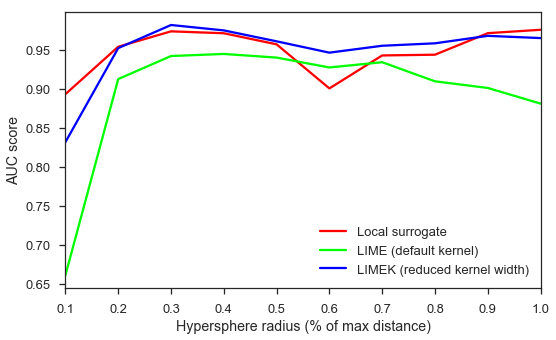

In [63]:
sns.set_style('ticks')
sns.set_context("talk")
global_ = pandas.DataFrame.from_dict(res_lime_global, orient='index')
local_ = pandas.DataFrame.from_dict(res_prop, orient='index')
kernel_ = pandas.DataFrame.from_dict(res_lime_kernel, orient='index')

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

ax = axs
ax = sns.tsplot(data=np.array(local_).T, err_style="ci_bars", condition="Local surrogate", time=local_.index, color="red")
ax = sns.tsplot(data=np.array(global_).T, err_style="ci_bars", condition="LIME (default kernel)", time=global_.index, color="lime")
ax = sns.tsplot(data=np.array(kernel_).T, err_style="ci_bars", condition="LIMEK (reduced kernel width)", time=local_.index, color="blue")
ax.set_xlabel('Hypersphere radius (% of max distance)')
ax.set_ylabel('AUC score')

tight_layout()
savefig('./illustrations/whi_radius_prop_toy2.pdf')

In [7]:
from sklearn.metrics import roc_auc_score

def accuracy(model_lime_pred, dataset, pred_fn, measure, label_toexplain):
    y_clf = pred_fn(dataset)[:,label_toexplain]
    y_pred_lime = model_lime_pred(dataset)
    return measure(y_clf, y_pred_lime) 

def lime_pred(obs, exp, label_toexplain, dataset_ref, regression): #entrée observation, sortie pred
    dataset_ref = (dataset_ref-exp.mean_)/exp.scale_
    surrogate = exp.easy_model[label_toexplain]
    y_m_surrogate_pred_proba =  surrogate.predict(obs.iloc[:,exp.used_features[label_toexplain]])
    if regression:
        return y_m_surrogate_pred_proba
    else:
        # OK for a binary classification problem
        y_m_surrogate_pred = numpy.zeros(obs.shape[0])
        mask = y_m_surrogate_pred_proba<0.5
        y_m_surrogate_pred[mask] = 1-label_toexplain
        mask = y_m_surrogate_pred_proba>=0.5
        y_m_surrogate_pred[mask] = label_toexplain
        return y_m_surrogate_pred

def lime_local_results(x_toexplain, dataset_train_lime, dataset_accuracy, pred_fn, label_toexplain, num_features, kernel_width=None):
    #entrée observation, dataset train lime, dataset accuracy, retour accuracy
    explainer = lime_assessment.lime_tabular.LimeTabularExplainer(dataset_train_lime, 
                                                                  discretize_continuous=False, kernel_width=kernel_width)
    exp = explainer.explain_instance(x_toexplain,
                                     pred_fn,
                                     num_features=num_features,
                                     top_labels=len(ylabels), 
                                     labels=range(len(ylabels)))
    
    
    regression = True
    model_lime_pred = lambda obs: lime_pred(obs, exp, label_toexplain, dataset_train_lime, regression=regression)
    if regression == False:
        pred_function = lambda obs: pred_fn(obs)>=0.5
        measure = accuracy_score
    else:
        pred_function = lambda obs: pred_fn(obs)>=0.5
        measure = roc_auc_score#r2_score
    acc = accuracy(model_lime_pred, dataset_accuracy, pred_function, measure, label_toexplain)
    
    '''
    ici on va sortir stab = stability()
    '''
    return acc

def prop_local_results(x_toexplain, dataset_train_lime, dataset_accuracy, pred_fn, label_toexplain, num_features, radius_train=0.3):
    #entrée observation, dataset train lime, dataset accuracy, retour accuracy
    #pred = lambda x: int(pred_fn(x)>=0.5)
    closest_enn, _ = gs.main(clf.predict, x_toexplain.reshape(1,-1), n_layer=1000, first_radius=0.1, step_size=100)
    closest_dist = float(pairwise_distances(x_toexplain.reshape(1,-1), closest_enn.reshape(1, -1))[0])
    X_local = generate_inside_ball(closest_enn.reshape(1,- 1), segment=(0, radius_train), n=1000)
    y_local = pred_fn(X_local)[:, 1]

    weights = np.ones(X_local.shape[0])
    used_features = feature_selection(X_local, y_local, weights, num_features, 'lasso_path')

    model_regressor = Ridge(alpha=1, fit_intercept=True,
                                    random_state=0)
    easy_model = model_regressor
    easy_model.fit(X_local[:, used_features],
                       y_local, sample_weight=weights)
    model_prop_pred = lambda obs: easy_model.predict(obs.iloc[:, used_features])
    
    
    regression = True
    if regression == False:
        pred_function = lambda obs: pred_fn(obs)>=0.5
        measure = accuracy_score
    else:
        pred_function = lambda obs: pred_fn(obs)>=0.5
        measure = roc_auc_score#r2_score
    acc = accuracy(model_prop_pred, dataset_accuracy, pred_function, measure, label_toexplain)
    return acc

def get_random_points_within_hypersphere(x_toexplain, r=1, N=100):
    # Generate N random points in a hypersphere of radius r
    res = []
    N_todraw = N
    while len(res) < N:
        N_todraw = N - len(res)
        X_generated = numpy.random.uniform(low=[x_toexplain-r for _ in range(N_todraw)], high=[x_toexplain+r for _ in range(N_todraw)])
        dists = euclidean_distances(x_toexplain.to_frame().T, X_generated)[0]
        for i in range(X_generated.shape[0]):
            if dists[i] < r:
                res.append(pandas.Series(X_generated[i], x_toexplain.index))
    X_generated = pandas.DataFrame(res)
    return X_generated




from __future__ import print_function
import numpy as np
from sklearn.linear_model import Ridge, lars_path
from sklearn.utils import check_random_state





def generate_lars_path(weighted_data, weighted_labels):
        """Generates the lars path for weighted data.

        Args:
            weighted_data: data that has been weighted by kernel
            weighted_label: labels, weighted by kernel

        Returns:
            (alphas, coefs), both are arrays corresponding to the
            regularization parameter and coefficients, respectively
        """
        x_vector = weighted_data
        alphas, _, coefs = lars_path(x_vector,
                                     weighted_labels,
                                     method='lasso',
                                     verbose=False)
        return alphas, coefs

def forward_selection(data, labels, weights, num_features):
        """Iteratively adds features to the model"""
        clf = Ridge(alpha=0, fit_intercept=True, random_state=0)
        used_features = []
        for _ in range(min(num_features, data.shape[1])):
            max_ = -100000000
            best = 0
            for feature in range(data.shape[1]):
                if feature in used_features:
                    continue
                clf.fit(data[:, used_features + [feature]], labels,
                        sample_weight=weights)
                score = clf.score(data[:, used_features + [feature]],
                                  labels,
                                  sample_weight=weights)
                if score > max_:
                    best = feature
                    max_ = score
            used_features.append(best)
        return np.array(used_features)
    
def feature_selection(data, labels, weights, num_features, method='lasso_path'):
        """Selects features for the model. see explain_instance_with_data to
           understand the parameters."""
        if method == 'none':
            return np.array(range(data.shape[1]))
        elif method == 'forward_selection':
            return forward_selection(data, labels, weights, num_features)
        elif method == 'highest_weights':
            clf = Ridge(alpha=0, fit_intercept=True,
                        random_state=0)
            clf.fit(data, labels, sample_weight=weights)
            feature_weights = sorted(zip(range(data.shape[0]),
                                         clf.coef_ * data[0]),
                                     key=lambda x: np.abs(x[1]),
                                     reverse=True)
            return np.array([x[0] for x in feature_weights[:num_features]])
        elif method == 'lasso_path':
            weighted_data = ((data - np.average(data, axis=0, weights=weights))
                             * np.sqrt(weights[:, np.newaxis]))
            weighted_labels = ((labels - np.average(labels, weights=weights))
                               * np.sqrt(weights))
            nonzero = range(weighted_data.shape[1])
            _, coefs = generate_lars_path(weighted_data,
                                               weighted_labels)
            for i in range(len(coefs.T) - 1, 0, -1):
                nonzero = coefs.T[i].nonzero()[0]
                if len(nonzero) <= num_features:
                    break
            used_features = nonzero
            return used_features
        elif method == 'auto':
            if num_features <= 6:
                n_method = 'forward_selection'
            else:
                n_method = 'highest_weights'
            return feature_selection(data, labels, weights,
                                          num_features, n_method)



# UCI

In [13]:
## Get dataset

from sklearn.datasets import load_wine, load_digits, fetch_20newsgroups_vectorized, make_classification, load_breast_cancer

import load_dataset

X, y = load_dataset.main('credit', n_obs=10000)
X = pandas.DataFrame(X)
y = pandas.Series(y)


'''data = load_wine()
#data = load_digits()
X = pandas.DataFrame(data.data)
y = pandas.Series(data.target)
print(X.shape)

X = (X - X.mean())/X.std()
'''
y = y[(X.abs()>3).sum(axis=1)==0]
X = X[(X.abs()>3).sum(axis=1)==0]

print(X.shape)

print(X.head())
print(y.head())
ylabels = ['Class 0', 'Class 1']
#feature_names = ['feature 0', 'feature 1']
'''plt.gray()
plt.matshow(X.iloc[50,:].reshape(8, 8))
plt.show()
'''

vars_ = ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
#vars_ = ['Round', 'FSP.1', 'FSW.1', 'SSP.1', 'SSW.1', 'UFE.1', 'BPC.1', 'BPW.1', 'NPA.1', 'NPW.1', 'TPW.1', 'FSP.2', 'FSW.2', 'SSP.2', 'SSW.2', 'UFE.2', 'BPC.2', 'BPW.2', 'NPA.2', 'NPW.2', 'TPW.2']

Columns kept: ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
0.2258
(8869, 20)
         0         1         2         3         4         5         6   \
0 -0.350208 -1.015029 -0.896343  1.760444  0.122690  0.199202  0.211956   
1 -0.889692  0.175697 -0.008083  0.106202  0.122690  0.199202  0.211956   
2 -0.889692  2.340652 -0.896343  0.106202 -0.691984  0.199202  0.211956   
3 -0.889692  0.175697 -0.008083  0.106202  0.122690  0.199202  0.211956   
5 -0.504346 -1.339772 -0.008083 -0.720918 -0.691984  0.199202  0.211956   

         7         8         9         10        11        12        13  \
0  1.928963 -0.652088 -0.659174 -0.637280 -0.603316 -0.593399 -0.580706   
1  0.232799 -0.030976  0.014879  0.070741 -0.191246 -0.165393 -0.135660   
2  0.232799 -0.568891 -0.601998 -0.133665 -0.312587 -0.330074 -0.31

In [14]:
## Train a back-box classifier on the synthetic dataset
import sklearn.model_selection, sklearn.ensemble



train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(X, y, test_size=0.10)

clf = sklearn.ensemble.RandomForestClassifier(n_estimators=200)
clf.fit(train, labels_train)
print(sklearn.metrics.accuracy_score(labels_test, clf.predict(test)))
print(sklearn.metrics.classification_report(labels_test, clf.predict(test)))

0.789177001127
             precision    recall  f1-score   support

          0       0.81      0.94      0.87       672
          1       0.63      0.31      0.41       215

avg / total       0.77      0.79      0.76       887



[0]


/home/laugel/Documents/thesis/code/new_envp36/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


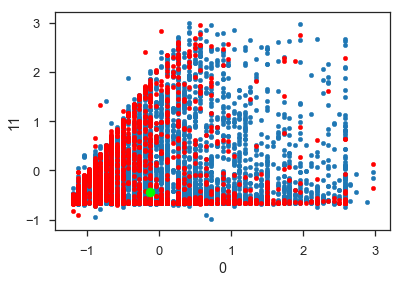

In [18]:
#idx = np.random.choice(test.index)
#x_toexplain = test.loc[idx]

AX1, AX2=0, 11

fig, ax = subplots(1)
X[y==0].plot(kind='scatter', x=AX1, y=AX2, ax=ax)
X[y==1].plot(kind='scatter', x=AX1, y=AX2, ax=ax, c='r')
print(clf.predict(x_toexplain.reshape(1,-1)))
ax.scatter(x_toexplain[AX1], x_toexplain[AX2], c='lime')
plt.show()

In [19]:
idx = np.random.choice(range(test.shape[0]))
x_toexplain = test.iloc[idx,:]
print(x_toexplain.shape)

num_features = 3#test.shape[1]

explainer = lime_assessment.lime_tabular.LimeTabularExplainer(test, discretize_continuous=False, kernel_width=None)
exp = explainer.explain_instance(x_toexplain,
                                     clf.predict_proba,
                                     num_features=num_features,
                                     top_labels=len(ylabels), 
                                     labels=range(len(ylabels)))
lime_features = exp.as_list()


radius_train = 1

closest_enn, _ = gs.main(clf.predict, x_toexplain.reshape(1,-1), n_layer=1000, first_radius=0.1, step_size=100)
closest_dist = float(pairwise_distances(x_toexplain.reshape(1,-1), closest_enn.reshape(1, -1))[0])
X_local = generate_inside_ball(closest_enn.reshape(1,- 1), segment=(0, 10 * closest_dist), n=1000)
y_local = clf.predict_proba(X_local)[:, 1]
weights = np.ones(X_local.shape[0])
used_features = feature_selection(X_local, y_local, weights, num_features, 'lasso_path')

model_regressor = Ridge(alpha=1, fit_intercept=True)
easy_model = model_regressor
easy_model.fit(X_local[:, used_features], y_local, sample_weight=weights)
prop_features = list(zip(used_features, easy_model.coef_))


lime_featuresd = [(vars_[int(x[0])], x[1]) for x in lime_features]
prop_featuresd = [(vars_[x[0]], x[1]) for x in prop_features]

lime_featuresd, prop_featuresd



(20,)


/home/laugel/Documents/thesis/code/new_envp36/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Exploring...
Final radius (0.8959844718999243, 0.9844271909999158)
Final number of iterations 9


/home/laugel/Documents/thesis/code/new_envp36/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


([('PAY_0', 0.024463192823341647),
  ('LIMIT_BAL', -0.017320131031524449),
  ('PAY_AMT1', -0.016797062213287819)],
 [('LIMIT_BAL', -0.0093354602255843761),
  ('PAY_0', 0.011321140776173357),
  ('PAY_AMT1', -0.0088378856933233902)])

In [20]:
clf.predict_proba(x_toexplain.reshape(1, -1))

/home/laugel/Documents/thesis/code/new_envp36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


array([[ 0.85,  0.15]])

([<matplotlib.axis.XTick at 0x7f1cd13609e8>,
 <a list of 2 Text xticklabel objects>)

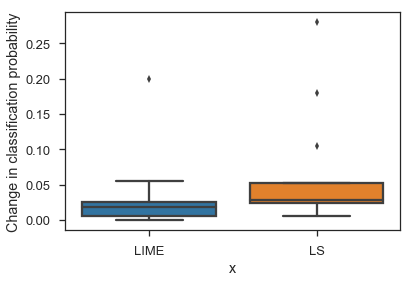

In [50]:
#pandas.Series(logoddratiolime).plot.box()
plt.show()
#pandas.Series(logoddratioprop).plot.box()

dfplot = pandas.DataFrame()
dfplot['Change in classification probability'] = logoddratiolime + logoddratioprop
dfplot['x'] = [0]*len(logoddratiolime) + [1]*len(logoddratioprop)



sns.boxplot(x='x', y='Change in classification probability', data=dfplot)
plt.xticks([0 , 1], ['LIME', 'LS'])

In [677]:
%%time
dataset = test
RADIUS_PERC = numpy.arange(3,11)/10.

KW = 2
res_lime_global = {}
res_lime_kernel = {}
res_prop = {}
dists = euclidean_distances(x_toexplain.to_frame().T, dataset)
dists = pandas.Series(dists[0], index=dataset.index)
radius = RADIUS_PERC*dists.max()

NUM_FEATURES = test.shape[1]

for i in range(len(radius)):
    print("======",i,"======")
    r = radius[i]

    X_t = pandas.DataFrame(generate_inside_ball(np.array(x_toexplain).reshape(1,-1), segment=(0,r), n=1000))#get_random_points_within_hypersphere(x_toexplain, r, N=1000)
    #X_t = dataset.loc[dists[dists<=r].index]
    global_lime_i = []
    kernel_lime_i = []
    prop_i = []
    
    for it in range(10):
        #print('1')
        glr = lime_local_results(x_toexplain,
                                 dataset,
                                 dataset_accuracy=X_t,
                                 pred_fn=clf.predict_proba,
                                 label_toexplain=1, num_features=NUM_FEATURES) 
        #print('2')
        klr = lime_local_results(x_toexplain,
                                 dataset,
                                 dataset_accuracy=X_t,
                                 pred_fn=clf.predict_proba,
                                 label_toexplain=1, kernel_width=KW, num_features=NUM_FEATURES)
        #klr = 0
        #print('3', X_t.shape)
        prop = prop_local_results(x_toexplain,
                                 dataset,
                                 dataset_accuracy=X_t,
                                 pred_fn=clf.predict_proba,
                                 label_toexplain=1,
                                 radius_train=0.3, num_features=NUM_FEATURES)
        #print('4')

        global_lime_i.append(glr)
        kernel_lime_i.append(klr)
        prop_i.append(prop)
    global_lime_i = np.array(global_lime_i)
    kernel_lime_i = np.array(kernel_lime_i)
    prop_i = np.array(prop_i)
    res_lime_global[RADIUS_PERC[i]] = global_lime_i
    res_lime_kernel[RADIUS_PERC[i]] = kernel_lime_i
    res_prop[RADIUS_PERC[i]] = prop_i



====== 0 ======


/home/laugel/Documents/thesis/code/new_envp36/lib/python3.6/site-packages/ipykernel_launcher.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Exploring...
Final radius (1.4109999999999985, 1.4299999999999984)
Final number of iterations 69


/home/laugel/Documents/thesis/code/new_envp36/lib/python3.6/site-packages/ipykernel_launcher.py:53: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Exploring...
Final radius (1.315999999999999, 1.3349999999999989)
Final number of iterations 64
Exploring...
Final radius (1.4489999999999983, 1.4679999999999982)
Final number of iterations 71
Exploring...
Final radius (1.4679999999999982, 1.486999999999998)
Final number of iterations 72
Exploring...
Final radius (1.5819999999999976, 1.6009999999999975)
Final number of iterations 78
Exploring...
Final radius (1.3349999999999989, 1.3539999999999988)
Final number of iterations 65
Exploring...
Final radius (1.4299999999999984, 1.4489999999999983)
Final number of iterations 70
Exploring...
Final radius (1.4299999999999984, 1.4489999999999983)
Final number of iterations 70
Exploring...
Final radius (1.4489999999999983, 1.4679999999999982)
Final number of iterations 71
Exploring...
Final radius (1.486999999999998, 1.505999999999998)
Final number of iterations 73
====== 1 ======
Exploring...
Final radius (1.5629999999999977, 1.5819999999999976)
Final number of iterations 77
Exploring...
Final

In [528]:
%%time
dataset = test
RADIUS_PERC = 0.2#numpy.arange(2,11)/10.
KW = 5

missing = 0
global_lime_i = []
kernel_lime_i = []
prop_i = []
for i in range(test.shape[0]):
    print("======",i,"======")
    x_toexplain = test.iloc[i,:]
    dists = euclidean_distances(x_toexplain.to_frame().T, dataset)
    dists = pandas.Series(dists[0], index=dataset.index)
    radius = RADIUS_PERC*dists.max()

    print('Radius used for accuracy', radius)
    X_t = pandas.DataFrame(generate_inside_ball(np.array(x_toexplain).reshape(1,-1), segment=(0,radius), n=1000))#get_random_points_within_hypersphere(x_toexplain, r, N=1000)

    #X_t = dataset.loc[dists[dists<=r].index]
    
    
    #for it in range(1):
    #print('1')
    try:
        glr = lime_local_results(x_toexplain,
                                 dataset,
                                 dataset_accuracy=X_t,
                                 pred_fn=clf.predict_proba,
                                 label_toexplain=1) 
        #print('2')
        klr = lime_local_results(x_toexplain,
                                 dataset,
                                 dataset_accuracy=X_t,
                                 pred_fn=clf.predict_proba,
                                 label_toexplain=1, kernel_width=KW)
        #klr = 0
        #print('3')
        prop = prop_local_results(x_toexplain,
                                 dataset,
                                 dataset_accuracy=X_t,
                                 pred_fn=clf.predict_proba,
                                 label_toexplain=1,
                                 radius_train=radius) #test utiliser meme radius pour accuracy et train (centres differents) = 0.3 distance max
        #print('4')

        global_lime_i.append(glr)
        kernel_lime_i.append(klr)
        prop_i.append(prop)
    except ValueError:
        missing += 1
global_lime_i = np.array(global_lime_i)
kernel_lime_i = np.array(kernel_lime_i)
prop_i = np.array(prop_i)
#res_lime_global[RADIUS_PERC[i]] = global_lime_i
#res_lime_kernel[RADIUS_PERC[i]] = kernel_lime_i
#res_prop[RADIUS_PERC[i]] = prop_i

print(global_lime_i.shape, kernel_lime_i.shape, prop_i.shape)
print('missing', missing)

====== 0 ======
Radius used for accuracy 2.34440090616


/home/laugel/Documents/thesis/code/new_envp36/lib/python3.6/site-packages/ipykernel_launcher.py:50: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Exploring...
Final radius (0.6700000000000003, 0.6890000000000003)
Final number of iterations 30
====== 1 ======
Radius used for accuracy 2.33064143154


/home/laugel/Documents/thesis/code/new_envp36/lib/python3.6/site-packages/ipykernel_launcher.py:51: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Exploring...
Final radius (0.138, 0.157)
Final number of iterations 2
====== 2 ======
Radius used for accuracy 2.38721677337
Exploring...
Final radius (0.23299999999999996, 0.25199999999999995)
Final number of iterations 7
====== 3 ======
Radius used for accuracy 2.33146710581
Exploring...
Final radius (0.36600000000000005, 0.38500000000000006)
Final number of iterations 14
====== 4 ======
Radius used for accuracy 2.11130673418
Exploring...
Final radius (0.11900000000000001, 0.138)
Final number of iterations 1
====== 5 ======
Radius used for accuracy 2.37158199752
Exploring...
Final radius (0.176, 0.19499999999999998)
Final number of iterations 4
====== 6 ======
Radius used for accuracy 2.39635514479
Exploring...
Final radius (0.5560000000000002, 0.5750000000000002)
Final number of iterations 24
====== 7 ======
Radius used for accuracy 2.7408626138
531 ennemies found. Zooming in...
Exploring...
Final radius (0.049800000000000004, 0.06970000000000001)
Final number of iterations 2
======

KeyboardInterrupt: 

In [529]:
print('Average Local AUC (r_acc=0.3):')
print('LIME (default):', global_lime_i.mean(), '(%f)'%global_lime_i.std())
print('Kernel LIME (k_w=%d):'%KW, kernel_lime_i.mean(), '(%f)'%kernel_lime_i.std())
print('Local Surrogate:', prop_i.mean(), '(%f)'%prop_i.std())


Average Local AUC (r_acc=0.3):


AttributeError: 'list' object has no attribute 'mean'

# LOOP UCI